<a href="https://colab.research.google.com/github/spatank/Curiosity/blob/master/v8/PH_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Curiosity_v8/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!ls # run !ls to verify location

build_Wiki_networks.ipynb	       persistent_homology_Wiki.ipynb
KNOT				       PH_plotting.ipynb
persistent_homology_KNOT.ipynb	       Simulations
persistent_homology_simulations.ipynb  Wiki


In [50]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def plot_barcode(bars, length, dims = [0, 1, 2], end = True):
    """
    Takes in bars, as generated by, e.g., ripser, and plots the barcode.
    """
    bars = dict(bars)
    count = 1
    has_inf = False
    colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
    # colors = ['#1b9e77','#d95f02','#7570b3']
    # iterate through dimension
    for d in dims:
        bn = bars[d]
        bn = sorted(bn, key = lambda x: x[0])
        for b, i in zip(bn, range(len(bn))):
            # extend in the case of infinite cycles
            if b[1] == np.inf:
                has_inf = True
                b = (b[0], 1.3*length)
            # plot first one with label
            if i == 0:
                plt.plot(b, [count, count], color = colors[d],
                         label='{}-cycles'.format(d))
            else:
                plt.plot(b, [count, count], color = colors[d])
            count += 1
        count += 1
    # add end of filtration line
    plt.axvline(x = length, color = 'xkcd:grey', alpha = 0.5, linestyle = ':')
    if end:
        plt.annotate('Filtration End', (length + 10, 0.5 * count), rotation = 270,
                     color = 'xkcd:grey', alpha = 0.5)
    lims = plt.xlim()
    plt.xlim([-0.05 * length, length * 1.05])
    plt.xlabel('Nodes')
    plt.ylabel('Cycle Number')

def betti_curves(bars, length):
    """
    Takes in bars and returns the betti curves
    """
    bettis = np.zeros((len(bars), length))
    for i in range(bettis.shape[0]):
        bn = bars[i][1]
        for bar in bn:
            birth = int(bar[0])
            death = length+1 if np.isinf(bar[1]) else int(bar[1]+1)
            bettis[i][birth:death] += 1
    return bettis

In [52]:
import sys
!{sys.executable} -m pip install traces

import traces

def time_normalize_and_merge(timeseries_lst, make_1_1 = False):
    """
    Takes in a list of time series (of possibly different lengths) and
    subsamples them using traces so they all range from 0 and 1 and are defined
    on the same points.
    """
    n_series = len(timeseries_lst)
    timeseries_lst = [traces.TimeSeries(zip(*(np.linspace(0, 1, len(ts)), ts)))
                      for ts in timeseries_lst]
    timeseries_lst = traces.TimeSeries.merge(timeseries_lst)
    if make_1_1:
        timeseries_lst[1.0] = [1.0] * n_series
    X = list(zip(*timeseries_lst.items()))[0]  # x values
    Y = list(zip(*timeseries_lst.items()))[1]  # y values across all series
    return X, Y

def plot_betti(bettis_lst, dim, null = 'none'):
  """
  Accepts a list of Betti curves, their associated dimension, and the identity of
  the null model used if the data come from one. 
  Plots average Betti curve with a standard deviation/error band.
  """
  
  # max_nodes = len(max(bettis_lst, key = lambda x: len(x)))
  max_nodes = max([len(lst) for lst in bettis_lst])
  bettis_mat = np.empty([len(bettis_lst), max_nodes])
  bettis_mat[:] = np.nan
  for i, j in enumerate(bettis_lst):
    bettis_mat[i][0:len(j)] = j
  numels = np.count_nonzero(~np.isnan(bettis_mat), axis = 0)
  mean = np.nanmean(bettis_mat, axis = 0)[numels != 1]
  std = np.nanstd(bettis_mat, axis = 0)[numels != 1]
  # mins = mean - std
  mins = mean - np.divide(std, np.sqrt(numels[numels != 1]))
  mins = np.maximum(0, mins)
  # maxes = mean + std
  maxes = mean + np.divide(std, np.sqrt(numels[numels != 1]))
  X = np.arange(len(numels[numels != 1]))

  colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
  if null == 'none':
    plt.plot(X, mean, color = colors[dim], label = '$\\beta_{}$'.format(dim),
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = colors[dim], alpha = 0.2)

  if null == 'edge_rewired':
    plt.plot(X, mean, color = '#7570b3', label = 'Edge Rewired',
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = '#7570b3', alpha = 0.2)

  if null == 'latticized':
    plt.plot(X, mean, color = '#d95f02', label = 'Latticized',
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = '#d95f02', alpha = 0.2)


def plot_betti_normalized_idx(bettis_lst, dim, null = 'none'):
  """
  Accepts a list of Betti curves, their associated dimension, and the identity of
  the null model used if the data come from one.
  Plots average Betti curve with a standard deviation/error band, and with the x-axis 
  normalized to be [0, 1].
  """
  
  X, Y = time_normalize_and_merge(bettis_lst)
  mean = np.mean(Y, axis = 1)
  # mins = np.mean(Y, axis = 1) - np.std(Y, axis = 1)
  mins = np.mean(Y, axis = 1) - np.std(Y, axis = 1)/np.sqrt(len(bettis_lst))
  mins = np.maximum(0, mins)
  # maxes = np.mean(Y, axis = 1) + np.std(Y, axis = 1)
  maxes = np.mean(Y, axis = 1) + np.std(Y, axis = 1)/np.sqrt(len(bettis_lst))

  colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
  if null == 'none':
    plt.plot(X, mean, color = colors[dim], label = '$\\beta_{}$'.format(dim),
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = colors[dim], alpha = 0.2)

  if null == 'edge_rewired':
    plt.plot(X, mean, color = '#7570b3', label = 'Edge Rewired',
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = '#7570b3', alpha = 0.2)

  if null == 'latticized':
    plt.plot(X, mean, color = '#d95f02', label = 'Latticized',
              linewidth = 1)
    plt.fill_between(X, mins, maxes, facecolor = '#d95f02', alpha = 0.2)

# KNOT 

In [53]:
base_path = '/content/drive/My Drive/Curiosity_v8/KNOT/Processed/PH_Python/'

## All Participants 

In [54]:
files = glob.glob(base_path + '*.npy')

all_num_nodes = []
all_bettis_0_orig = []
all_bettis_1_orig = []
all_bettis_2_orig = []
all_bettis_0_edges_rewired = []
all_bettis_1_edges_rewired = []
all_bettis_2_edges_rewired = []
all_bettis_0_latticized = []
all_bettis_1_latticized = []
all_bettis_2_latticized = []

for idx, PH_file in enumerate(files):
  data = np.load(PH_file, allow_pickle = True)
  data_dict = data.item()
  num_nodes = data_dict['num_nodes']
  all_num_nodes.append(num_nodes)
  # bars_orig = data_dict['bars_orig']
  bettis_orig = data_dict['bettis_orig']
  all_bettis_0_orig.append(bettis_orig[0])
  all_bettis_1_orig.append(bettis_orig[1])
  all_bettis_2_orig.append(bettis_orig[2])
  bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
  all_bettis_0_edges_rewired.append(list(np.mean(np.array(bettis_0_edges_rewired), axis = 0)))
  bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
  all_bettis_1_edges_rewired.append(list(np.mean(np.array(bettis_1_edges_rewired), axis = 0)))
  bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
  all_bettis_2_edges_rewired.append(list(np.mean(np.array(bettis_2_edges_rewired), axis = 0)))
  bettis_0_latticized = data_dict['bettis_0_latticized']
  all_bettis_0_latticized.append(list(np.mean(np.array(bettis_0_latticized), axis = 0)))
  bettis_1_latticized = data_dict['bettis_1_latticized']
  all_bettis_1_latticized.append(list(np.mean(np.array(bettis_1_latticized), axis = 0)))
  bettis_2_latticized = data_dict['bettis_2_latticized']
  all_bettis_2_latticized.append(list(np.mean(np.array(bettis_2_latticized), axis = 0)))

In a Betti curve derived from a node-filtered order complex, the x-axis is usually comprised of node indices corresponding to the order in which nodes are added to the growing graph. However, people build networks of different sizes as demonstrated in the histogram below. 

Text(0, 0.5, 'Participants')

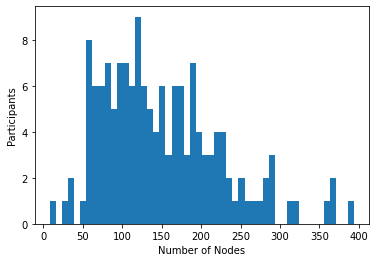

In [55]:
plt.hist(all_num_nodes, density = False, bins = 50)  
plt.xlabel('Number of Nodes')
plt.ylabel('Participants')

We can normalize the x-axis so that the filtration index for all participants ranges between 0 and 1. Thus, we can align values across all sub-sampled Betti curves before taking averages and plotting them. We plot these index normalized plots next to the unprocessed ones.

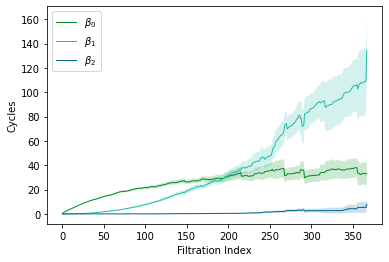

In [56]:
plot_betti(all_bettis_0_orig, 0)
plot_betti(all_bettis_1_orig, 1)
plot_betti(all_bettis_2_orig, 2)
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

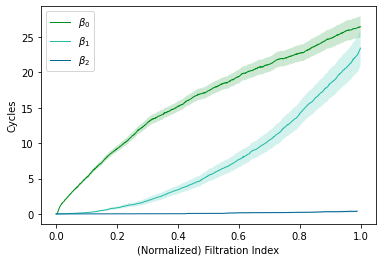

In [57]:
plot_betti_normalized_idx(all_bettis_0_orig, 0)
plot_betti_normalized_idx(all_bettis_1_orig, 1)
plot_betti_normalized_idx(all_bettis_2_orig, 2)
plt.xlabel('(Normalized) Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

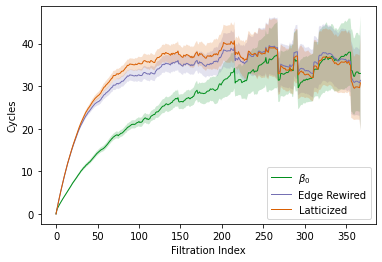

In [58]:
plot_betti(all_bettis_0_orig, 0)
plot_betti(all_bettis_0_edges_rewired, 0, null = 'edge_rewired')
plot_betti(all_bettis_0_latticized, 0, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "lower right")

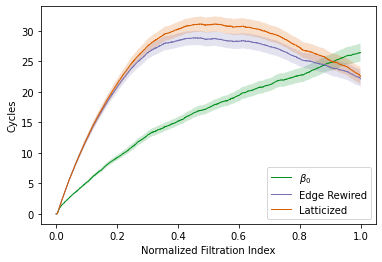

In [59]:
plot_betti_normalized_idx(all_bettis_0_orig, 0)
plot_betti_normalized_idx(all_bettis_0_edges_rewired, 0, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_0_latticized, 0, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "lower right")

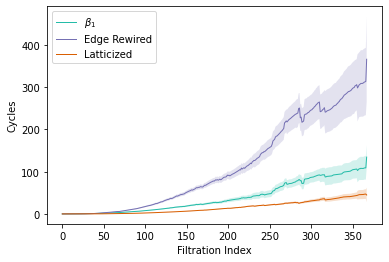

In [60]:
plot_betti(all_bettis_1_orig, 1)
plot_betti(all_bettis_1_edges_rewired, 1, null = 'edge_rewired')
plot_betti(all_bettis_1_latticized, 1, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

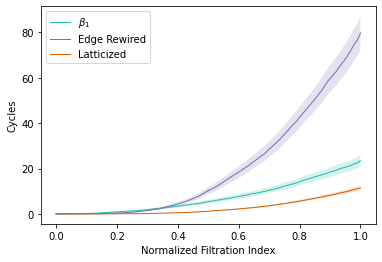

In [61]:
plot_betti_normalized_idx(all_bettis_1_orig, 1)
plot_betti_normalized_idx(all_bettis_1_edges_rewired, 1, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_1_latticized, 1, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

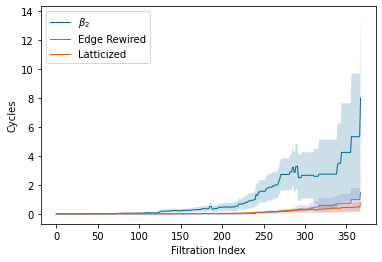

In [62]:
plot_betti(all_bettis_2_orig, 2)
plot_betti(all_bettis_2_edges_rewired, 2, null = 'edge_rewired')
plot_betti(all_bettis_2_latticized, 2, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

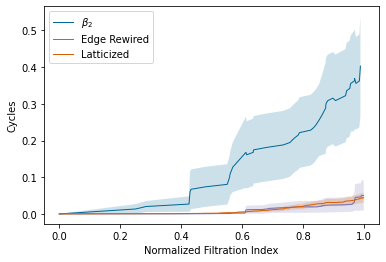

In [63]:
plot_betti_normalized_idx(all_bettis_2_orig, 2)
plot_betti_normalized_idx(all_bettis_2_edges_rewired, 2, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_2_latticized, 2, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

## One Participant

In [64]:
subj_ID = 106
data = np.load(base_path + 'subj_' + str(subj_ID) + '_PH.npy', allow_pickle = True)
data_dict = data.item()

num_nodes = data_dict['num_nodes']
bars_orig = data_dict['bars_orig']
bettis_orig = data_dict['bettis_orig']
bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
bettis_0_latticized = data_dict['bettis_0_latticized']
bettis_1_latticized = data_dict['bettis_1_latticized']
bettis_2_latticized = data_dict['bettis_2_latticized']

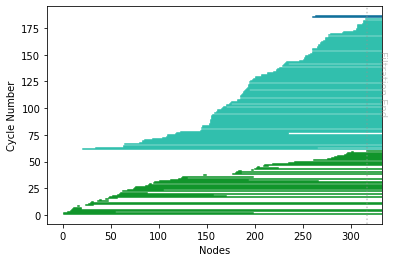

In [65]:
plot_barcode(bars_orig, num_nodes)

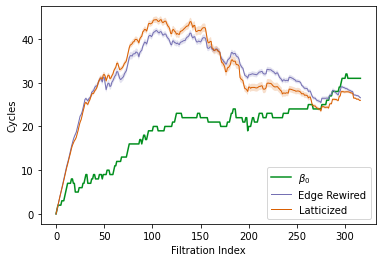

In [66]:
dim = 0
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_0_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_0_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "lower right")

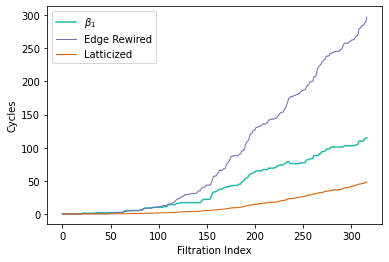

In [67]:
dim = 1
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_1_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_1_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

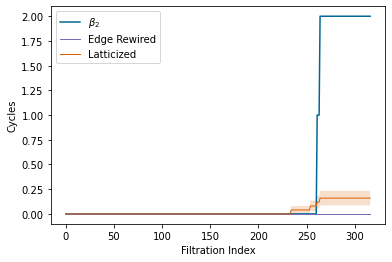

In [68]:
dim = 2
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_2_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_2_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

# Wikipedia Networks

In [69]:
base_path = '/content/drive/My Drive/Curiosity_v8/Wiki/Processed/PH_Python/'

## All Topics

In [70]:
files = glob.glob(base_path + '*.npy')

all_num_nodes = []
all_bettis_0_orig = []
all_bettis_1_orig = []
all_bettis_2_orig = []
all_bettis_0_edges_rewired = []
all_bettis_1_edges_rewired = []
all_bettis_2_edges_rewired = []
all_bettis_0_latticized = []
all_bettis_1_latticized = []
all_bettis_2_latticized = []

for idx, PH_file in enumerate(files):
  data = np.load(PH_file, allow_pickle = True)
  data_dict = data.item()
  num_nodes = data_dict['num_nodes']
  all_num_nodes.append(num_nodes)
  # bars_orig = data_dict['bars_orig']
  bettis_orig = data_dict['bettis_orig']
  all_bettis_0_orig.append(bettis_orig[0])
  all_bettis_1_orig.append(bettis_orig[1])
  all_bettis_2_orig.append(bettis_orig[2])
  bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
  all_bettis_0_edges_rewired.append(list(np.mean(np.array(bettis_0_edges_rewired), axis = 0)))
  bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
  all_bettis_1_edges_rewired.append(list(np.mean(np.array(bettis_1_edges_rewired), axis = 0)))
  bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
  all_bettis_2_edges_rewired.append(list(np.mean(np.array(bettis_2_edges_rewired), axis = 0)))
  bettis_0_latticized = data_dict['bettis_0_latticized']
  all_bettis_0_latticized.append(list(np.mean(np.array(bettis_0_latticized), axis = 0)))
  bettis_1_latticized = data_dict['bettis_1_latticized']
  all_bettis_1_latticized.append(list(np.mean(np.array(bettis_1_latticized), axis = 0)))
  bettis_2_latticized = data_dict['bettis_2_latticized']
  all_bettis_2_latticized.append(list(np.mean(np.array(bettis_2_latticized), axis = 0)))

Text(0, 0.5, 'Topics')

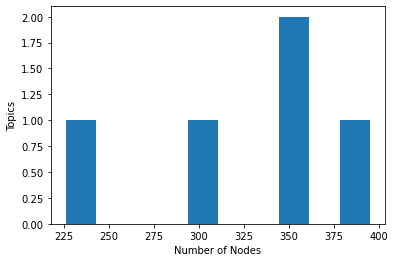

In [71]:
plt.hist(all_num_nodes, density = False)  
plt.xlabel('Number of Nodes')
plt.ylabel('Topics')

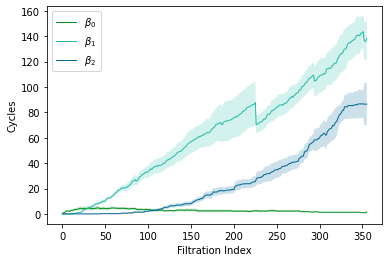

In [72]:
plot_betti(all_bettis_0_orig, 0)
plot_betti(all_bettis_1_orig, 1)
plot_betti(all_bettis_2_orig, 2)
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

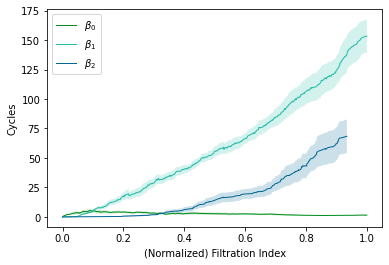

In [73]:
plot_betti_normalized_idx(all_bettis_0_orig, 0)
plot_betti_normalized_idx(all_bettis_1_orig, 1)
plot_betti_normalized_idx(all_bettis_2_orig, 2)
plt.xlabel('(Normalized) Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

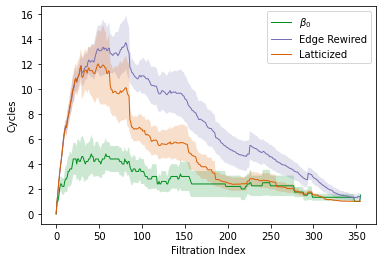

In [74]:
plot_betti(all_bettis_0_orig, 0)
plot_betti(all_bettis_0_edges_rewired, 0, null = 'edge_rewired')
plot_betti(all_bettis_0_latticized, 0, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper right")

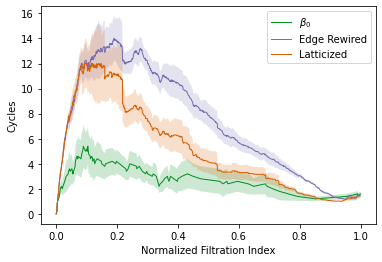

In [75]:
plot_betti_normalized_idx(all_bettis_0_orig, 0)
plot_betti_normalized_idx(all_bettis_0_edges_rewired, 0, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_0_latticized, 0, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper right")

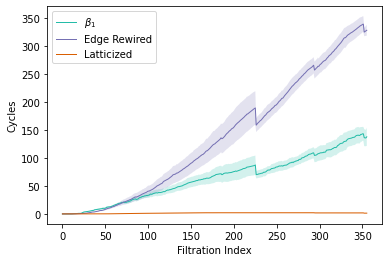

In [76]:
plot_betti(all_bettis_1_orig, 1)
plot_betti(all_bettis_1_edges_rewired, 1, null = 'edge_rewired')
plot_betti(all_bettis_1_latticized, 1, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

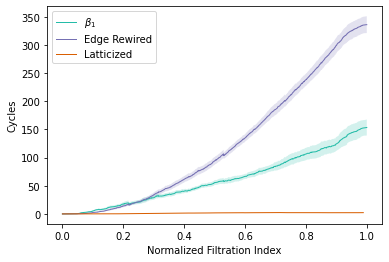

In [77]:
plot_betti_normalized_idx(all_bettis_1_orig, 1)
plot_betti_normalized_idx(all_bettis_1_edges_rewired, 1, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_1_latticized, 1, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

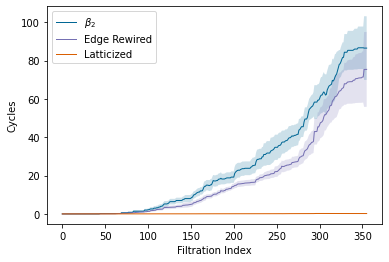

In [78]:
plot_betti(all_bettis_2_orig, 2)
plot_betti(all_bettis_2_edges_rewired, 2, null = 'edge_rewired')
plot_betti(all_bettis_2_latticized, 2, null = 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

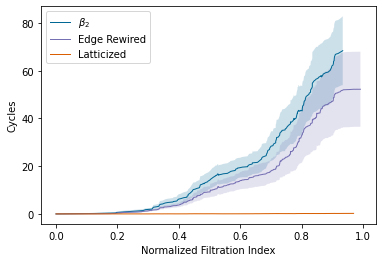

In [79]:
plot_betti_normalized_idx(all_bettis_2_orig, 2)
plot_betti_normalized_idx(all_bettis_2_edges_rewired, 2, null = 'edge_rewired')
plot_betti_normalized_idx(all_bettis_2_latticized, 2, null = 'latticized')
plt.xlabel('Normalized Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

## One Topic

In [80]:
topic_ID = 'software_engineering'
data = np.load(base_path + topic_ID + '_PH.npy', allow_pickle = True)
data_dict = data.item()

num_nodes = data_dict['num_nodes']
bars_orig = data_dict['bars_orig']
bettis_orig = data_dict['bettis_orig']
bettis_0_edges_rewired = data_dict['bettis_0_edges_rewired']
bettis_1_edges_rewired = data_dict['bettis_1_edges_rewired']
bettis_2_edges_rewired = data_dict['bettis_2_edges_rewired']
bettis_0_latticized = data_dict['bettis_0_latticized']
bettis_1_latticized = data_dict['bettis_1_latticized']
bettis_2_latticized = data_dict['bettis_2_latticized']

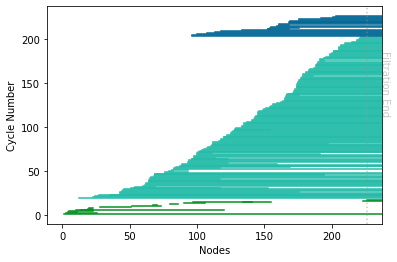

In [81]:
plot_barcode(bars_orig, num_nodes)

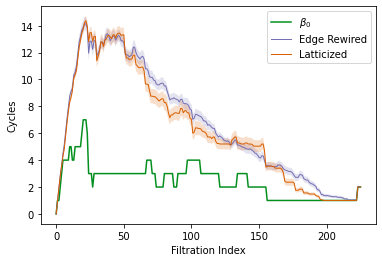

In [82]:
dim = 0
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_0_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_0_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper right")

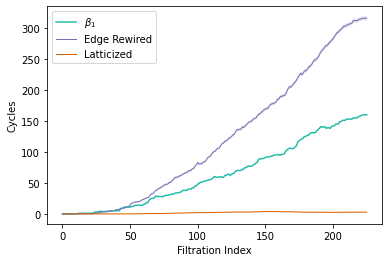

In [83]:
dim = 1
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_1_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_1_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

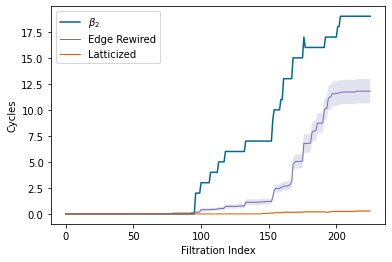

In [84]:
dim = 2
X = np.arange(num_nodes)
colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
plt.plot(X, bettis_orig[dim], color = colors[dim], label = '$\\beta_{}$'.format(dim))
plot_betti(bettis_2_edges_rewired, dim, 'edge_rewired')
plot_betti(bettis_2_latticized, dim, 'latticized')
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

# Simulated Networks

In [85]:
data_path = '/content/drive/My Drive/Curiosity_v8/Simulations/simulated_nets_PH.npy'
data = np.load(data_path, allow_pickle = True)
data_dict = data.item()
num_nodes = data_dict['num_nodes']

## Constant Probability Model

In [86]:
bars_CP = data_dict['bars_CP']
bettis_0_CP = data_dict['bettis_0_CP']
bettis_1_CP = data_dict['bettis_1_CP']
bettis_2_CP = data_dict['bettis_2_CP']

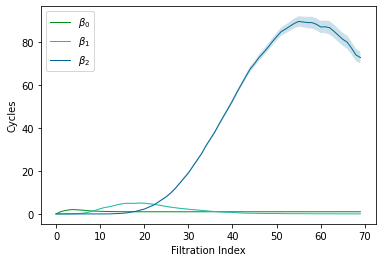

In [87]:
plot_betti(bettis_0_CP, 0)
plot_betti(bettis_1_CP, 1)
plot_betti(bettis_2_CP, 2)
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

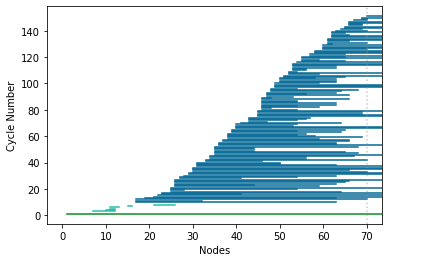

In [88]:
plot_barcode(bars_CP, num_nodes)

## Proportional Probability Model

In [89]:
bars_PP = data_dict['bars_PP']
bettis_0_PP = data_dict['bettis_0_PP']
bettis_1_PP = data_dict['bettis_1_PP']
bettis_2_PP = data_dict['bettis_2_PP']

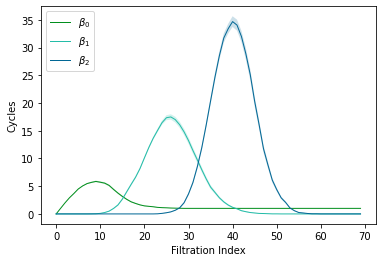

In [90]:
plot_betti(bettis_0_PP, 0)
plot_betti(bettis_1_PP, 1)
plot_betti(bettis_2_PP, 2)
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

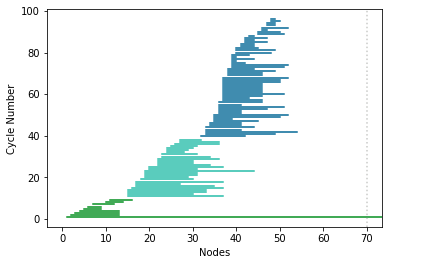

In [91]:
plot_barcode(bars_PP, num_nodes)

## Preferential Attachment Model

In [92]:
bars_PA = data_dict['bars_PA']
bettis_0_PA = data_dict['bettis_0_PA']
bettis_1_PA = data_dict['bettis_1_PA']
bettis_2_PA = data_dict['bettis_2_PA']

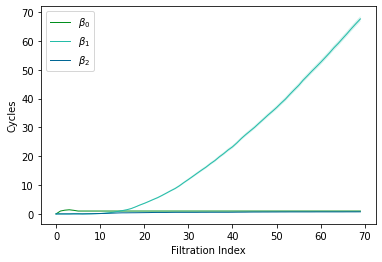

In [93]:
plot_betti(bettis_0_PA, 0)
plot_betti(bettis_1_PA, 1)
plot_betti(bettis_2_PA, 2)
plt.xlabel('Filtration Index')
plt.ylabel('Cycles')
plt.legend(loc = "upper left")

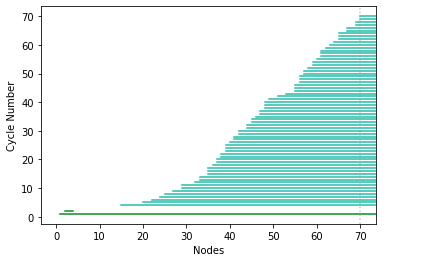

In [94]:
plot_barcode(bars_PA, num_nodes)